# Week 9 Assignment: What makes a good index?

## Author: Bailey Jørgensen

In [28]:
# %pip install sqlite3

# Import libraries
import sqlite3
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Note: I was having trouble with the DB being read-only, so I made a copy like so:
# Open the original read-only DB
readonly_conn = sqlite3.connect("/courses/EDS213/big-fat.sqlite3")

# Create an in-memory writable DB
mem_conn = sqlite3.connect(":memory:")

# Copy the entire database into memory
readonly_conn.backup(mem_conn)

# Create the cursor
cur = mem_conn.cursor()

# Execute a query
cur.execute("SELECT * FROM Site")
cur.fetchone()

('barr', 'Barrow', 'Alaska, USA', 71.3, -156.6, 220.4)

In [29]:
# Query we will be working with for the assignment
cur.execute("""SELECT Nest_ID
    FROM Bird_nests
    WHERE Site = 'nome' AND
          Species = 'ruff' AND
          Year = 1983 AND
          Observer = 'cbishop' AND
          ageMethod = 'float';""")

result = cur.fetchone()

print("Nest ID: ", result)

Nest ID:  ('gen511190',)


### Part 1:
Answer the following questions.

- Is there already an index on the Bird_nests table? If so, what is that index and will SQLite use it in the above query? Why or why not?

In [30]:
# Check to see if there is are indexes 
cur.execute("""PRAGMA index_list(Bird_nests);""")
result = cur.fetchall()

print(result)

[(0, 'sqlite_autoindex_Bird_nests_1', 1, 'pk', 0)]


In [31]:
# See if this index is used in this query
cur.execute("""EXPLAIN QUERY PLAN 
    SELECT Nest_ID
    FROM Bird_nests
    WHERE Site = 'nome' AND
          Species = 'ruff' AND
          Year = 1983 AND
          Observer = 'cbishop' AND
          ageMethod = 'float';""")
result = cur.fetchall()
print(result)

[(2, 0, 0, 'SCAN Bird_nests')]


It looks like, based on the searches above, that there is one index already on the Bird_nests table. However, that index is not used in the Query for this assingment, because the query plan involves "SCAN Bird_nests", which is the entire table.

- Will adding an index on a column not mentioned in the WHERE clause be used by the database? Why or why not?

Since the existing index does not live on any of the columns mentioned by the WHERE clause, it is not used during the query. This makes sense, since the database has no need to use the indexes and columns not called in the query. 

### Part 2:

I didn't particularly enjoy creating and using the Bash test harness before, so I decided to try out doing the timings in Python instead.

Experiment One: 
    
    

In [32]:
# Query to be tested
query = """
    SELECT Nest_ID
    FROM Bird_nests
    WHERE Site = 'nome' AND
          Species = 'ruff' AND
          Year = 1983 AND
          Observer = 'cbishop' AND
          ageMethod = 'float';
"""

repetitions = 10  # This seemed like a nice middle of the road number that didn't take too long to run

# Time the query
start = time.time()
for _ in range(repetitions):
    cur.execute(query)
    cur.fetchall()
end = time.time()

# Compute average query time
avg_time = (end - start) / repetitions

# Since no index is used, distinct count is 1 as per instructions
distinct_count = 1

# Print result
print("Label: none")
print(f"Average query time: {avg_time:.8f} seconds")
print(f"Number of distinct values: {distinct_count}")


Label: none
Average query time: 0.81752255 seconds
Number of distinct values: 1


Experiment 2: Now adding an index...

In [33]:
# Query to test
query = """
    SELECT Nest_ID
    FROM Bird_nests
    WHERE Site = 'nome' AND
          Species = 'ruff' AND
          Year = 1983 AND
          Observer = 'cbishop' AND
          ageMethod = 'float';
"""

repetitions = 10
index_name = "idx_Site"

# Create index on Site
cur.execute(f"CREATE INDEX {index_name} ON Bird_nests (Site)")

# Time the query
start = time.time()
for _ in range(repetitions):
    cur.execute(query)
    cur.fetchall()
end = time.time()
avg_time = (end - start) / repetitions

# Count distinct Site values
cur.execute("SELECT COUNT(DISTINCT Site) FROM Bird_nests")
distinct_count = cur.fetchone()[0]

# Drop the index
cur.execute(f"DROP INDEX IF EXISTS {index_name}")

# Output the results
print("Label: Site")
print(f"Average query time: {avg_time:.8f} seconds")
print(f"Number of distinct values: {distinct_count}")

Label: Site
Average query time: 0.10294945 seconds
Number of distinct values: 16


Awesome, it's working and I can see that the query time is improving with an index already. However, doing these one by one is going to take forever...time to automate my process, and write the results to a csv.

In [34]:
# Parameters - first define query
query = """
    SELECT Nest_ID
    FROM Bird_nests
    WHERE Site = 'nome' AND
          Species = 'ruff' AND
          Year = 1983 AND
          Observer = 'cbishop' AND
          ageMethod = 'float';
"""
repetitions = 10  

# Define all index configurations for the 15 experiments
index_experiments = [
    ("none", None),  # baseline (no index)
    ("Site", ["Site"]),
    ("Species", ["Species"]),
    ("Year", ["Year"]),
    ("Observer", ["Observer"]),
    ("ageMethod", ["ageMethod"]),
    # Columns with more than 1 index
    ("Site,Species", ["Site", "Species"]),
    ("Site,Observer", ["Site", "Observer"]),
    ("Species,Observer", ["Species", "Observer"]),
    ("Year,Observer", ["Year", "Observer"]),
    ("Observer,ageMethod", ["Observer", "ageMethod"]),
    ("Site,Species,Observer", ["Site", "Species", "Observer"]),
    ("Site,Species,Year", ["Site", "Species", "Year"]),
    ("Species,Year,Observer", ["Species", "Year", "Observer"]),
    ("Site,Species,Year,Observer", ["Site", "Species", "Year", "Observer"])
]

# Results list
results = []

# Create a for loop to create the index
for label, columns in index_experiments:
    print(f"Running experiment: {label}")
    
    try:
        # If columns specified, create an index; NOTE: Had to replace symbols to avoid errors 
        index_name = f"idx_{label.replace(',', '_').replace(' ', '')}"
        if columns:
            col_str = ", ".join(columns)
            cur.execute(f"CREATE INDEX {index_name} ON Bird_nests ({col_str})")
            print(f"  Created index: {index_name}")
        
        # Time the query
        start = time.time()
        for _ in range(repetitions):
            cur.execute(query)
            cur.fetchall()
        end = time.time()
        avg_time = (end - start) / repetitions
        print(f"  Average query time: {avg_time:.6f} seconds")
        
        # Count distinct values in the indexed columns
        if columns:
            if len(columns) == 1:
                # Single column - use COUNT(DISTINCT column)
                distinct_query = f"SELECT COUNT(DISTINCT {columns[0]}) FROM Bird_nests"
            else:
                # Multiple columns - use COUNT(*) with GROUP BY to count distinct combinations
                col_str = ", ".join(columns)
                distinct_query = f"SELECT COUNT(*) FROM (SELECT DISTINCT {col_str} FROM Bird_nests)"
            
            cur.execute(distinct_query)
            distinct_count = cur.fetchone()[0]
        else:
            distinct_count = 1  # Accounts for first experiment
        
        print(f"  Distinct values: {distinct_count}")
        
        # Save results
        results.append((label, avg_time, distinct_count))
        
    except Exception as e:
        print(f"  ERROR in experiment '{label}': {e}")
        # Still record the result with an error marker (this came in handy during development)
        results.append((label, "ERROR", "ERROR"))
    
    finally:
        # Always try to drop the index, even if there was an error
        if columns:
            try:
                cur.execute(f"DROP INDEX IF EXISTS {index_name}")
                print(f"  Dropped index: {index_name}")
            except Exception as e:
                print(f"  Warning: Could not drop index {index_name}: {e}")
    
    print("-" * 40) # Just makes it fancy!

# Write results to CSV
with open("index_experiment_results.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["label", "avg_query_time", "num_distinct_values"])
    writer.writerows(results)

print("Experiments complete. Results saved to 'index_experiment_results.csv'.")

# Display summary
print("\nSummary of Results:")
print("=" * 60)
for label, avg_time, distinct_count in results:
    if avg_time != "ERROR":
        print(f"{label:25} | {avg_time:10.6f}s | {distinct_count:8} distinct")
    else:
        print(f"{label:25} | {'ERROR':>10} | {'ERROR':>8}")

Running experiment: none
  Average query time: 0.787428 seconds
  Distinct values: 1
----------------------------------------
Running experiment: Site
  Created index: idx_Site
  Average query time: 0.103952 seconds
  Distinct values: 16
  Dropped index: idx_Site
----------------------------------------
Running experiment: Species
  Created index: idx_Species
  Average query time: 0.020617 seconds
  Distinct values: 99
  Dropped index: idx_Species
----------------------------------------
Running experiment: Year
  Created index: idx_Year
  Average query time: 0.029866 seconds
  Distinct values: 66
  Dropped index: idx_Year
----------------------------------------
Running experiment: Observer
  Created index: idx_Observer
  Average query time: 0.006044 seconds
  Distinct values: 269
  Dropped index: idx_Observer
----------------------------------------
Running experiment: ageMethod
  Created index: idx_ageMethod
  Average query time: 0.434225 seconds
  Distinct values: 3
  Dropped index

In [35]:
# Cleanup and close connections!
mem_conn.close()
readonly_conn.close()

In [36]:
# Read in the csv I created
experiment_results = pd.read_csv("index_experiment_results.csv")
experiment_results.head()

,label,avg_query_time,num_distinct_values
0,none,0.787428,1
1,Site,0.103952,16
2,Species,0.020617,99
3,Year,0.029866,66
4,Observer,0.006044,269


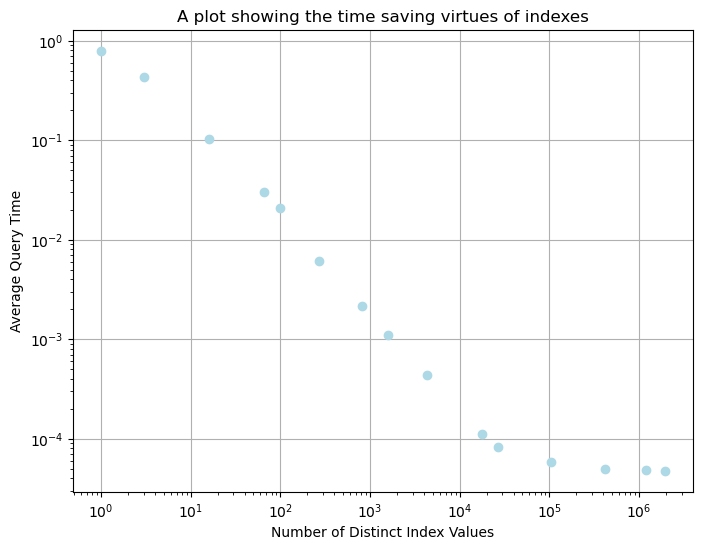

In [37]:
# Make a line plot of my results
plt.figure(figsize=(8,6))

# Use log transformed values
plt.loglog(experiment_results["num_distinct_values"], experiment_results["avg_query_time"], 'o', color='lightblue')

# Labels
plt.xlabel("Number of Distinct Index Values")
plt.ylabel("Average Query Time")
plt.title("A plot showing the time saving virtues of indexes")

# Finish plot
plt.grid(True)
plt.show()

## Conclusion:

- What relationship do you observe? Hypothesize why you see the relationship you do.

I see that average query time goes down as the number of distinct index values goes up. However, at around 10^5 it starts leveling out. So, at a certain point, the number of index values no longer makes a difference on the length of run time for a query. Perhaps because, once the query is narrowed down enough, additional indexes are redundant.

- What conclusion do you draw regarding what makes a good index?

In conclusion, I think that a good index is one that strikes the balance between enough index values to reduce run time, but not so many as to be redundant.

### Citations and Credits: 

https://www.sqlitetutorial.net/sqlite-index/

https://matthewsetter.com/sqlite-attempt-to-write-to-readonly-database/

https://stackoverflow.com/questions/3319112/sqlite-error-attempt-to-write-a-readonly-database-during-insert

https://stackoverflow.com/questions/64236409/how-can-i-get-the-execution-time-of-an-sql-query-using-mysql-connector-in-python

https://eds-217-essential-python.github.io/cheatsheets.html

https://docs.python.org/3/tutorial/errors.html

and Michelle Yiv and Madison Enda for coworking with me and helping me troubleshoot!